# VAE Representations for SQLi

In [1]:
import os, datetime
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence

## Collect HTML files

Load the HTML files

In [2]:
files = []

for f in os.listdir(os.path.join(os.getcwd(),'html')):
    fd = open(os.path.join(os.getcwd(),'html',f),'r')
    content = fd.read()
    files.append(content)
    fd.close()

Show a sample file

In [3]:
files[0]

'\n<!-- saved from url=(0042)http://jabba.hackingarena.no:806/index.php -->\n<html><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"></head><body>Login as admin for the flag!\n<br>some content, some content\n<form action="http://jabba.hackingarena.no:806/index.php" method="post">\n<table width="100">\n<tbody><tr><td>Name:</td>\n<td><input type="text" name="username" value=""></td></tr>\n<tr><td>Password:</td>\n<td><input type="text" name="passwd" value=""></td></tr>\n\n<tr><td><input type="submit" value="Submit"></td></tr>\n</tbody></table>\n</form>\n\n</body></html>\n'

Add a mock file as a concatentation of a previous one

In [4]:
files.append(files[0]*10)

## Preprocess the files

Define the tokenization, padding and trimming parameters

In [5]:
lower = False
filters = '"#$%&()*+,.;?@[\\]^_`{|}~\t\n'

padding='post'

maxlen=200
truncating='post'

Show an example of tokenization

In [6]:
text_to_word_sequence(files[0],lower=lower, filters=filters)

['<!--',
 'saved',
 'from',
 'url=',
 '0042',
 'http://jabba',
 'hackingarena',
 'no:806/index',
 'php',
 '-->',
 '<html><head><meta',
 'http-equiv=',
 'Content-Type',
 'content=',
 'text/html',
 'charset=UTF-8',
 '></head><body>Login',
 'as',
 'admin',
 'for',
 'the',
 'flag!',
 '<br>some',
 'content',
 'some',
 'content',
 '<form',
 'action=',
 'http://jabba',
 'hackingarena',
 'no:806/index',
 'php',
 'method=',
 'post',
 '>',
 '<table',
 'width=',
 '100',
 '>',
 '<tbody><tr><td>Name:</td>',
 '<td><input',
 'type=',
 'text',
 'name=',
 'username',
 'value=',
 '></td></tr>',
 '<tr><td>Password:</td>',
 '<td><input',
 'type=',
 'text',
 'name=',
 'passwd',
 'value=',
 '></td></tr>',
 '<tr><td><input',
 'type=',
 'submit',
 'value=',
 'Submit',
 '></td></tr>',
 '</tbody></table>',
 '</form>',
 '</body></html>']

Learn a tokenization dictionary and convert the pages into token sequences:

In [7]:
SQLi_tokenizer = Tokenizer(lower=lower, filters=filters)
SQLi_tokenizer.fit_on_texts(files)
tokens_list = SQLi_tokenizer.texts_to_sequences(files)

Pad and trim the sequences to fit them into an array:

In [8]:
tokens_array = keras.preprocessing.sequence.pad_sequences(tokens_list, padding=padding, maxlen=maxlen, truncating=truncating)

## Defining VAE

Instantiating a VAE module built following [https://keras.io/examples/generative/vae/](https://keras.io/examples/generative/vae/).

*Sampling layer with reparametrization trick* $z_i\sim\mathcal{N}(\mu_\phi, \sigma_\phi)$

In [9]:
class Sampling(layers.Layer):
    
    def call(self,inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(.5 * z_log_var) * epsilon

*Encoder* $Q_\phi(z \vert x)$

In [10]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(200,))

x = layers.Dense(100,activation='relu')(encoder_inputs)
x = layers.Dense(25,activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean,z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean,z_log_var,z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          20100       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 25)           2525        dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            52          dense_1[0][0]                    
____________________________________________________________________________________________

*Decoder* $P_\theta(x\vert z)$

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(25,activation='relu')(latent_inputs)
x = layers.Dense(100,activation='relu')(x)
decoder_outputs = layers.Dense(200,activation='relu')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2600      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20200     
Total params: 22,875
Trainable params: 22,875
Non-trainable params: 0
_________________________________________________________________


*VAE with KL+reconstruction loss*

In [12]:
class VAE(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)           
            reconstruction = self.decoder(z)
            print(reconstruction)
            reconstruction_loss = keras.losses.mean_squared_error(data,reconstruction)
            #reconstruction_loss = tf.reduce_sum(keras.losses.mean_squared_error(data,reconstruction), axis=1)
            kl_loss = -.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = (tf.reduce_sum(kl_loss,axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }

## Training the VAE

Instantiating and training the model

In [13]:
vae = VAE(encoder,decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(tokens_array, epochs=2000, batch_size=3)

Epoch 1/2000
Tensor("decoder/dense_4/Relu:0", shape=(None, 200), dtype=float32)
Tensor("decoder/dense_4/Relu:0", shape=(None, 200), dtype=float32)
2/2 [==============================] - 0s 15ms/step - loss: 812.9162 - reconstruction_loss: 273.3965 - kl_loss: 496.9340
Epoch 2/2000
2/2 [==============================] - 0s 7ms/step - loss: 381.7134 - reconstruction_loss: 282.2567 - kl_loss: 114.4396
Epoch 3/2000
2/2 [==============================] - 0s 2ms/step - loss: 339.8919 - reconstruction_loss: 282.9966 - kl_loss: 33.9527
Epoch 4/2000
2/2 [==============================] - 0s 14ms/step - loss: 356.2154 - reconstruction_loss: 280.4507 - kl_loss: 50.2152
Epoch 5/2000
2/2 [==============================] - 0s 2ms/step - loss: 332.7120 - reconstruction_loss: 278.4251 - kl_loss: 96.1859
Epoch 6/2000
2/2 [==============================] - 0s 3ms/step - loss: 359.0772 - reconstruction_loss: 276.8267 - kl_loss: 62.9270
Epoch 7/2000
2/2 [==============================] - 0s 3ms/step - loss

2/2 [==============================] - 0s 8ms/step - loss: 157.9568 - reconstruction_loss: 133.2801 - kl_loss: 14.2690
Epoch 62/2000
2/2 [==============================] - 0s 25ms/step - loss: 171.9506 - reconstruction_loss: 138.8314 - kl_loss: 20.9653
Epoch 63/2000
2/2 [==============================] - 0s 2ms/step - loss: 143.0953 - reconstruction_loss: 135.0470 - kl_loss: 19.2883
Epoch 64/2000
2/2 [==============================] - 0s 2ms/step - loss: 139.5250 - reconstruction_loss: 135.4601 - kl_loss: 16.6437
Epoch 65/2000
2/2 [==============================] - 0s 2ms/step - loss: 165.6157 - reconstruction_loss: 134.7661 - kl_loss: 18.4522
Epoch 66/2000
2/2 [==============================] - 0s 3ms/step - loss: 128.9665 - reconstruction_loss: 124.0282 - kl_loss: 17.9204
Epoch 67/2000
2/2 [==============================] - 0s 3ms/step - loss: 135.1347 - reconstruction_loss: 134.1585 - kl_loss: 14.4560
Epoch 68/2000
2/2 [==============================] - 0s 4ms/step - loss: 131.9623 

2/2 [==============================] - 0s 2ms/step - loss: 112.7941 - reconstruction_loss: 91.7661 - kl_loss: 15.2425
Epoch 123/2000
2/2 [==============================] - 0s 2ms/step - loss: 116.6879 - reconstruction_loss: 92.2145 - kl_loss: 16.4214
Epoch 124/2000
2/2 [==============================] - 0s 3ms/step - loss: 114.6930 - reconstruction_loss: 87.3706 - kl_loss: 20.1258
Epoch 125/2000
2/2 [==============================] - 0s 2ms/step - loss: 107.5603 - reconstruction_loss: 86.4800 - kl_loss: 16.0781
Epoch 126/2000
2/2 [==============================] - 0s 3ms/step - loss: 109.3085 - reconstruction_loss: 93.4014 - kl_loss: 13.3269
Epoch 127/2000
2/2 [==============================] - 0s 4ms/step - loss: 99.0484 - reconstruction_loss: 91.9194 - kl_loss: 15.0875
Epoch 128/2000
2/2 [==============================] - 0s 3ms/step - loss: 93.1280 - reconstruction_loss: 82.0066 - kl_loss: 17.5767
Epoch 129/2000
2/2 [==============================] - 0s 3ms/step - loss: 111.4837 - r

2/2 [==============================] - 0s 2ms/step - loss: 91.2534 - reconstruction_loss: 76.2877 - kl_loss: 11.7000
Epoch 183/2000
2/2 [==============================] - 0s 3ms/step - loss: 74.8985 - reconstruction_loss: 67.9712 - kl_loss: 12.5659
Epoch 184/2000
2/2 [==============================] - 0s 8ms/step - loss: 89.4289 - reconstruction_loss: 70.0882 - kl_loss: 15.5349
Epoch 185/2000
2/2 [==============================] - 0s 6ms/step - loss: 92.3088 - reconstruction_loss: 73.3817 - kl_loss: 13.6170
Epoch 186/2000
2/2 [==============================] - 0s 3ms/step - loss: 93.9804 - reconstruction_loss: 80.6937 - kl_loss: 11.4792
Epoch 187/2000
2/2 [==============================] - 0s 7ms/step - loss: 86.3639 - reconstruction_loss: 71.3758 - kl_loss: 11.7747
Epoch 188/2000
2/2 [==============================] - 0s 7ms/step - loss: 92.3554 - reconstruction_loss: 72.6565 - kl_loss: 16.3893
Epoch 189/2000
2/2 [==============================] - 0s 7ms/step - loss: 81.8323 - reconst

2/2 [==============================] - 0s 17ms/step - loss: 99.4211 - reconstruction_loss: 81.7410 - kl_loss: 10.7962
Epoch 243/2000
2/2 [==============================] - 0s 4ms/step - loss: 77.9505 - reconstruction_loss: 67.1793 - kl_loss: 18.1832
Epoch 244/2000
2/2 [==============================] - 0s 24ms/step - loss: 81.6773 - reconstruction_loss: 64.2636 - kl_loss: 13.6245
Epoch 245/2000
2/2 [==============================] - 0s 3ms/step - loss: 120.4310 - reconstruction_loss: 144.2176 - kl_loss: 6.3652
Epoch 246/2000
2/2 [==============================] - 0s 2ms/step - loss: 94.6749 - reconstruction_loss: 80.0303 - kl_loss: 9.9598
Epoch 247/2000
2/2 [==============================] - 0s 3ms/step - loss: 207.7900 - reconstruction_loss: 233.3735 - kl_loss: 46.1265
Epoch 248/2000
2/2 [==============================] - 0s 3ms/step - loss: 137.2193 - reconstruction_loss: 100.0674 - kl_loss: 27.5577
Epoch 249/2000
2/2 [==============================] - 0s 3ms/step - loss: 143.6795 - 

2/2 [==============================] - 0s 3ms/step - loss: 79.1427 - reconstruction_loss: 61.6111 - kl_loss: 13.6133
Epoch 304/2000
2/2 [==============================] - 0s 2ms/step - loss: 69.4054 - reconstruction_loss: 61.1876 - kl_loss: 13.0832
Epoch 305/2000
2/2 [==============================] - 0s 6ms/step - loss: 77.8406 - reconstruction_loss: 61.6313 - kl_loss: 12.5212
Epoch 306/2000
2/2 [==============================] - 0s 2ms/step - loss: 69.0894 - reconstruction_loss: 60.9885 - kl_loss: 12.2853
Epoch 307/2000
2/2 [==============================] - 0s 2ms/step - loss: 81.7125 - reconstruction_loss: 62.6849 - kl_loss: 12.4189
Epoch 308/2000
2/2 [==============================] - 0s 4ms/step - loss: 70.6454 - reconstruction_loss: 63.0000 - kl_loss: 12.0097
Epoch 309/2000
2/2 [==============================] - 0s 3ms/step - loss: 73.2268 - reconstruction_loss: 64.6196 - kl_loss: 12.2550
Epoch 310/2000
2/2 [==============================] - 0s 4ms/step - loss: 71.9641 - reconst

2/2 [==============================] - 0s 5ms/step - loss: 74.1538 - reconstruction_loss: 61.9670 - kl_loss: 10.9205
Epoch 365/2000
2/2 [==============================] - 0s 4ms/step - loss: 76.0231 - reconstruction_loss: 60.0991 - kl_loss: 12.0298
Epoch 366/2000
2/2 [==============================] - 0s 6ms/step - loss: 76.6397 - reconstruction_loss: 58.7933 - kl_loss: 12.1594
Epoch 367/2000
2/2 [==============================] - 0s 3ms/step - loss: 65.2740 - reconstruction_loss: 61.0658 - kl_loss: 10.6764
Epoch 368/2000
2/2 [==============================] - 0s 7ms/step - loss: 65.6751 - reconstruction_loss: 63.2890 - kl_loss: 9.0019
Epoch 369/2000
2/2 [==============================] - 0s 10ms/step - loss: 75.6054 - reconstruction_loss: 61.3093 - kl_loss: 9.0351
Epoch 370/2000
2/2 [==============================] - 0s 9ms/step - loss: 72.9050 - reconstruction_loss: 58.7442 - kl_loss: 10.4822
Epoch 371/2000
2/2 [==============================] - 0s 8ms/step - loss: 65.8808 - reconstr

2/2 [==============================] - 0s 5ms/step - loss: 60.9450 - reconstruction_loss: 56.4274 - kl_loss: 8.9624
Epoch 427/2000
2/2 [==============================] - 0s 6ms/step - loss: 66.4689 - reconstruction_loss: 57.5661 - kl_loss: 8.8362
Epoch 428/2000
2/2 [==============================] - 0s 4ms/step - loss: 57.2654 - reconstruction_loss: 55.0134 - kl_loss: 9.0137
Epoch 429/2000
2/2 [==============================] - 0s 3ms/step - loss: 63.1776 - reconstruction_loss: 57.9519 - kl_loss: 9.1747
Epoch 430/2000
2/2 [==============================] - 0s 3ms/step - loss: 60.9708 - reconstruction_loss: 56.0290 - kl_loss: 8.9097
Epoch 431/2000
2/2 [==============================] - 0s 3ms/step - loss: 58.4402 - reconstruction_loss: 56.7836 - kl_loss: 8.7749
Epoch 432/2000
2/2 [==============================] - 0s 4ms/step - loss: 69.5632 - reconstruction_loss: 55.9111 - kl_loss: 9.0753
Epoch 433/2000
2/2 [==============================] - 0s 6ms/step - loss: 60.2944 - reconstruction

2/2 [==============================] - 0s 28ms/step - loss: 64.4647 - reconstruction_loss: 53.1721 - kl_loss: 9.5356
Epoch 489/2000
2/2 [==============================] - 0s 4ms/step - loss: 55.2291 - reconstruction_loss: 53.1156 - kl_loss: 9.1394
Epoch 490/2000
2/2 [==============================] - 0s 25ms/step - loss: 55.6574 - reconstruction_loss: 52.3278 - kl_loss: 8.6542
Epoch 491/2000
2/2 [==============================] - 0s 11ms/step - loss: 65.6200 - reconstruction_loss: 51.7843 - kl_loss: 8.7433
Epoch 492/2000
2/2 [==============================] - 0s 4ms/step - loss: 54.0625 - reconstruction_loss: 51.9131 - kl_loss: 9.1592
Epoch 493/2000
2/2 [==============================] - 0s 7ms/step - loss: 57.6981 - reconstruction_loss: 52.0339 - kl_loss: 9.2180
Epoch 494/2000
2/2 [==============================] - 0s 7ms/step - loss: 56.7951 - reconstruction_loss: 51.4221 - kl_loss: 8.8870
Epoch 495/2000
2/2 [==============================] - 0s 4ms/step - loss: 55.6448 - reconstruct

2/2 [==============================] - 0s 4ms/step - loss: 64.3786 - reconstruction_loss: 62.9469 - kl_loss: 11.8413
Epoch 551/2000
2/2 [==============================] - 0s 10ms/step - loss: 75.0917 - reconstruction_loss: 59.6345 - kl_loss: 10.3381
Epoch 552/2000
2/2 [==============================] - 0s 10ms/step - loss: 102.3967 - reconstruction_loss: 85.4553 - kl_loss: 6.8592
Epoch 553/2000
2/2 [==============================] - 0s 5ms/step - loss: 95.1896 - reconstruction_loss: 70.2058 - kl_loss: 15.0970
Epoch 554/2000
2/2 [==============================] - 0s 11ms/step - loss: 128.1104 - reconstruction_loss: 96.2630 - kl_loss: 20.6892
Epoch 555/2000
2/2 [==============================] - 0s 12ms/step - loss: 79.0827 - reconstruction_loss: 57.1939 - kl_loss: 15.7833
Epoch 556/2000
2/2 [==============================] - 0s 7ms/step - loss: 67.4170 - reconstruction_loss: 70.0430 - kl_loss: 9.9214
Epoch 557/2000
2/2 [==============================] - 0s 6ms/step - loss: 93.8974 - rec

2/2 [==============================] - 0s 6ms/step - loss: 50.9960 - reconstruction_loss: 45.4651 - kl_loss: 10.2136
Epoch 612/2000
2/2 [==============================] - 0s 5ms/step - loss: 60.3217 - reconstruction_loss: 45.6969 - kl_loss: 10.3997
Epoch 613/2000
2/2 [==============================] - 0s 7ms/step - loss: 52.0653 - reconstruction_loss: 49.1707 - kl_loss: 9.6109
Epoch 614/2000
2/2 [==============================] - 0s 2ms/step - loss: 52.1977 - reconstruction_loss: 48.9078 - kl_loss: 9.3909
Epoch 615/2000
2/2 [==============================] - 0s 3ms/step - loss: 49.1271 - reconstruction_loss: 45.8344 - kl_loss: 9.7359
Epoch 616/2000
2/2 [==============================] - 0s 21ms/step - loss: 58.6472 - reconstruction_loss: 45.3305 - kl_loss: 9.8822
Epoch 617/2000
2/2 [==============================] - 0s 5ms/step - loss: 62.9474 - reconstruction_loss: 49.5929 - kl_loss: 9.4576
Epoch 618/2000
2/2 [==============================] - 0s 4ms/step - loss: 50.5476 - reconstruct

2/2 [==============================] - 0s 3ms/step - loss: 48.7462 - reconstruction_loss: 44.9232 - kl_loss: 9.5332
Epoch 674/2000
2/2 [==============================] - 0s 3ms/step - loss: 61.1630 - reconstruction_loss: 50.4719 - kl_loss: 8.0098
Epoch 675/2000
2/2 [==============================] - 0s 4ms/step - loss: 79.0043 - reconstruction_loss: 65.3411 - kl_loss: 6.5779
Epoch 676/2000
2/2 [==============================] - ETA: 0s - loss: 35.7774 - reconstruction_loss: 29.0494 - kl_loss: 6.728 - 0s 4ms/step - loss: 48.6938 - reconstruction_loss: 47.2139 - kl_loss: 7.9381
Epoch 677/2000
2/2 [==============================] - 0s 4ms/step - loss: 52.6915 - reconstruction_loss: 48.5138 - kl_loss: 10.5495
Epoch 678/2000
2/2 [==============================] - 0s 4ms/step - loss: 66.1466 - reconstruction_loss: 49.1639 - kl_loss: 11.7141
Epoch 679/2000
2/2 [==============================] - 0s 7ms/step - loss: 59.1458 - reconstruction_loss: 45.6684 - kl_loss: 10.1111
Epoch 680/2000
2/2 [=

Epoch 735/2000
2/2 [==============================] - 0s 9ms/step - loss: 49.5705 - reconstruction_loss: 40.1958 - kl_loss: 7.6173
Epoch 736/2000
2/2 [==============================] - 0s 6ms/step - loss: 51.2254 - reconstruction_loss: 39.7567 - kl_loss: 7.5621
Epoch 737/2000
2/2 [==============================] - 0s 6ms/step - loss: 52.1218 - reconstruction_loss: 39.8063 - kl_loss: 7.7114
Epoch 738/2000
2/2 [==============================] - 0s 4ms/step - loss: 45.2642 - reconstruction_loss: 42.1558 - kl_loss: 8.3258
Epoch 739/2000
2/2 [==============================] - 0s 7ms/step - loss: 44.8991 - reconstruction_loss: 41.6314 - kl_loss: 7.6159
Epoch 740/2000
2/2 [==============================] - 0s 6ms/step - loss: 45.1324 - reconstruction_loss: 42.3132 - kl_loss: 7.1726
Epoch 741/2000
2/2 [==============================] - 0s 11ms/step - loss: 53.5278 - reconstruction_loss: 43.1758 - kl_loss: 7.5615
Epoch 742/2000
2/2 [==============================] - 0s 4ms/step - loss: 44.1648 

2/2 [==============================] - 0s 4ms/step - loss: 45.9981 - reconstruction_loss: 40.3959 - kl_loss: 14.0420
Epoch 797/2000
2/2 [==============================] - 0s 3ms/step - loss: 57.8880 - reconstruction_loss: 40.4814 - kl_loss: 14.3228
Epoch 798/2000
2/2 [==============================] - 0s 9ms/step - loss: 57.9658 - reconstruction_loss: 38.6343 - kl_loss: 14.7450
Epoch 799/2000
2/2 [==============================] - 0s 4ms/step - loss: 57.8466 - reconstruction_loss: 38.1998 - kl_loss: 15.3661
Epoch 800/2000
2/2 [==============================] - 0s 8ms/step - loss: 48.9740 - reconstruction_loss: 42.0036 - kl_loss: 15.8481
Epoch 801/2000
2/2 [==============================] - 0s 4ms/step - loss: 57.7575 - reconstruction_loss: 38.8299 - kl_loss: 15.6168
Epoch 802/2000
2/2 [==============================] - 0s 5ms/step - loss: 56.9199 - reconstruction_loss: 37.9212 - kl_loss: 14.7902
Epoch 803/2000
2/2 [==============================] - 0s 8ms/step - loss: 59.2781 - reconst

2/2 [==============================] - 0s 12ms/step - loss: 50.6783 - reconstruction_loss: 37.2120 - kl_loss: 10.6531
Epoch 859/2000
2/2 [==============================] - 0s 4ms/step - loss: 50.3423 - reconstruction_loss: 36.4018 - kl_loss: 10.3887
Epoch 860/2000
2/2 [==============================] - 0s 10ms/step - loss: 40.3037 - reconstruction_loss: 36.5074 - kl_loss: 10.2180
Epoch 861/2000
2/2 [==============================] - 0s 9ms/step - loss: 49.7769 - reconstruction_loss: 36.0569 - kl_loss: 10.3170
Epoch 862/2000
2/2 [==============================] - 0s 4ms/step - loss: 50.7345 - reconstruction_loss: 35.0358 - kl_loss: 10.5107
Epoch 863/2000
2/2 [==============================] - 0s 5ms/step - loss: 50.2012 - reconstruction_loss: 35.4998 - kl_loss: 10.7118
Epoch 864/2000
2/2 [==============================] - 0s 6ms/step - loss: 41.2141 - reconstruction_loss: 36.2215 - kl_loss: 10.6805
Epoch 865/2000
2/2 [==============================] - 0s 7ms/step - loss: 48.9217 - recon

2/2 [==============================] - 0s 4ms/step - loss: 46.2333 - reconstruction_loss: 34.1132 - kl_loss: 8.3751
Epoch 921/2000
2/2 [==============================] - 0s 4ms/step - loss: 46.9574 - reconstruction_loss: 34.1758 - kl_loss: 8.2515
Epoch 922/2000
2/2 [==============================] - 0s 3ms/step - loss: 46.5427 - reconstruction_loss: 34.8677 - kl_loss: 8.2140
Epoch 923/2000
2/2 [==============================] - 0s 2ms/step - loss: 45.8651 - reconstruction_loss: 33.9676 - kl_loss: 8.2421
Epoch 924/2000
2/2 [==============================] - 0s 3ms/step - loss: 44.2032 - reconstruction_loss: 33.5115 - kl_loss: 8.3651
Epoch 925/2000
2/2 [==============================] - 0s 14ms/step - loss: 47.1363 - reconstruction_loss: 33.8595 - kl_loss: 8.4912
Epoch 926/2000
2/2 [==============================] - 0s 14ms/step - loss: 38.8927 - reconstruction_loss: 35.7983 - kl_loss: 8.5206
Epoch 927/2000
2/2 [==============================] - 0s 6ms/step - loss: 45.0560 - reconstructi

2/2 [==============================] - 0s 5ms/step - loss: 35.0459 - reconstruction_loss: 33.3231 - kl_loss: 7.0503
Epoch 983/2000
2/2 [==============================] - 0s 7ms/step - loss: 35.2399 - reconstruction_loss: 32.4920 - kl_loss: 7.2731
Epoch 984/2000
2/2 [==============================] - 0s 5ms/step - loss: 36.6820 - reconstruction_loss: 33.8466 - kl_loss: 7.3767
Epoch 985/2000
2/2 [==============================] - 0s 8ms/step - loss: 46.8511 - reconstruction_loss: 35.5200 - kl_loss: 7.2781
Epoch 986/2000
2/2 [==============================] - 0s 4ms/step - loss: 47.6765 - reconstruction_loss: 37.7285 - kl_loss: 7.0509
Epoch 987/2000
2/2 [==============================] - 0s 4ms/step - loss: 38.3417 - reconstruction_loss: 35.5473 - kl_loss: 6.9707
Epoch 988/2000
2/2 [==============================] - 0s 6ms/step - loss: 35.5825 - reconstruction_loss: 34.2507 - kl_loss: 6.8399
Epoch 989/2000
2/2 [==============================] - 0s 4ms/step - loss: 44.9589 - reconstruction

2/2 [==============================] - 0s 4ms/step - loss: 36.9856 - reconstruction_loss: 36.1088 - kl_loss: 6.2357
Epoch 1044/2000
2/2 [==============================] - 0s 3ms/step - loss: 33.3312 - reconstruction_loss: 32.7473 - kl_loss: 6.2098
Epoch 1045/2000
2/2 [==============================] - 0s 10ms/step - loss: 34.8706 - reconstruction_loss: 33.3476 - kl_loss: 6.4386
Epoch 1046/2000
2/2 [==============================] - 0s 5ms/step - loss: 42.2327 - reconstruction_loss: 33.2721 - kl_loss: 6.8989
Epoch 1047/2000
2/2 [==============================] - 0s 3ms/step - loss: 38.5446 - reconstruction_loss: 36.2078 - kl_loss: 7.1907
Epoch 1048/2000
2/2 [==============================] - 0s 4ms/step - loss: 35.8919 - reconstruction_loss: 33.3474 - kl_loss: 6.8798
Epoch 1049/2000
2/2 [==============================] - 0s 5ms/step - loss: 43.6750 - reconstruction_loss: 33.6551 - kl_loss: 6.4946
Epoch 1050/2000
2/2 [==============================] - 0s 7ms/step - loss: 34.0124 - recons

2/2 [==============================] - 0s 4ms/step - loss: 42.3273 - reconstruction_loss: 32.4510 - kl_loss: 6.4116
Epoch 1105/2000
2/2 [==============================] - 0s 4ms/step - loss: 42.0709 - reconstruction_loss: 32.3913 - kl_loss: 6.2884
Epoch 1106/2000
2/2 [==============================] - 0s 12ms/step - loss: 41.6601 - reconstruction_loss: 32.1348 - kl_loss: 6.4143
Epoch 1107/2000
2/2 [==============================] - 0s 4ms/step - loss: 42.7487 - reconstruction_loss: 34.0496 - kl_loss: 6.5303
Epoch 1108/2000
2/2 [==============================] - 0s 5ms/step - loss: 40.6535 - reconstruction_loss: 31.4078 - kl_loss: 6.5247
Epoch 1109/2000
2/2 [==============================] - 0s 4ms/step - loss: 43.1343 - reconstruction_loss: 33.1219 - kl_loss: 6.3667
Epoch 1110/2000
2/2 [==============================] - 0s 5ms/step - loss: 32.0155 - reconstruction_loss: 30.9865 - kl_loss: 6.3978
Epoch 1111/2000
2/2 [==============================] - 0s 5ms/step - loss: 41.1879 - recons

2/2 [==============================] - 0s 4ms/step - loss: 42.1264 - reconstruction_loss: 32.2582 - kl_loss: 6.1820
Epoch 1167/2000
2/2 [==============================] - 0s 4ms/step - loss: 39.7707 - reconstruction_loss: 31.1780 - kl_loss: 6.1616
Epoch 1168/2000
2/2 [==============================] - 0s 6ms/step - loss: 40.2126 - reconstruction_loss: 30.7476 - kl_loss: 6.2382
Epoch 1169/2000
2/2 [==============================] - 0s 5ms/step - loss: 33.0175 - reconstruction_loss: 31.8440 - kl_loss: 6.2473
Epoch 1170/2000
2/2 [==============================] - 0s 6ms/step - loss: 39.4516 - reconstruction_loss: 30.0874 - kl_loss: 6.2453
Epoch 1171/2000
2/2 [==============================] - 0s 9ms/step - loss: 41.1857 - reconstruction_loss: 31.5964 - kl_loss: 5.9367
Epoch 1172/2000
2/2 [==============================] - 0s 3ms/step - loss: 41.1874 - reconstruction_loss: 31.7132 - kl_loss: 5.9302
Epoch 1173/2000
2/2 [==============================] - 0s 4ms/step - loss: 33.8444 - reconst

2/2 [==============================] - 0s 7ms/step - loss: 43.4882 - reconstruction_loss: 33.2257 - kl_loss: 6.1336
Epoch 1228/2000
2/2 [==============================] - 0s 4ms/step - loss: 40.2428 - reconstruction_loss: 30.0157 - kl_loss: 6.6133
Epoch 1229/2000
2/2 [==============================] - 0s 7ms/step - loss: 41.8212 - reconstruction_loss: 31.1941 - kl_loss: 6.9658
Epoch 1230/2000
2/2 [==============================] - 0s 5ms/step - loss: 30.6262 - reconstruction_loss: 29.2962 - kl_loss: 6.5466
Epoch 1231/2000
2/2 [==============================] - 0s 5ms/step - loss: 38.8710 - reconstruction_loss: 29.3174 - kl_loss: 6.2614
Epoch 1232/2000
2/2 [==============================] - 0s 3ms/step - loss: 41.9079 - reconstruction_loss: 32.2541 - kl_loss: 5.8544
Epoch 1233/2000
2/2 [==============================] - 0s 3ms/step - loss: 29.8947 - reconstruction_loss: 29.0865 - kl_loss: 6.0406
Epoch 1234/2000
2/2 [==============================] - 0s 4ms/step - loss: 40.3439 - reconst

2/2 [==============================] - 0s 5ms/step - loss: 49.1476 - reconstruction_loss: 37.9159 - kl_loss: 5.7058
Epoch 1289/2000
2/2 [==============================] - 0s 6ms/step - loss: 33.8403 - reconstruction_loss: 32.6795 - kl_loss: 5.9122
Epoch 1290/2000
2/2 [==============================] - 0s 5ms/step - loss: 40.5420 - reconstruction_loss: 30.6547 - kl_loss: 6.2865
Epoch 1291/2000
2/2 [==============================] - 0s 3ms/step - loss: 49.0553 - reconstruction_loss: 36.7309 - kl_loss: 6.7666
Epoch 1292/2000
2/2 [==============================] - 0s 9ms/step - loss: 38.7806 - reconstruction_loss: 28.8790 - kl_loss: 6.3331
Epoch 1293/2000
2/2 [==============================] - 0s 9ms/step - loss: 38.6067 - reconstruction_loss: 29.4942 - kl_loss: 6.0150
Epoch 1294/2000
2/2 [==============================] - 0s 6ms/step - loss: 33.1771 - reconstruction_loss: 32.7381 - kl_loss: 6.0069
Epoch 1295/2000
2/2 [==============================] - 0s 8ms/step - loss: 41.7757 - reconst

2/2 [==============================] - 0s 4ms/step - loss: 29.3249 - reconstruction_loss: 28.4308 - kl_loss: 5.8853
Epoch 1351/2000
2/2 [==============================] - 0s 5ms/step - loss: 30.8403 - reconstruction_loss: 31.1334 - kl_loss: 5.8196
Epoch 1352/2000
2/2 [==============================] - 0s 3ms/step - loss: 38.6543 - reconstruction_loss: 29.1788 - kl_loss: 5.9659
Epoch 1353/2000
2/2 [==============================] - 0s 3ms/step - loss: 43.3360 - reconstruction_loss: 33.2132 - kl_loss: 6.2180
Epoch 1354/2000
2/2 [==============================] - 0s 6ms/step - loss: 39.1598 - reconstruction_loss: 30.3476 - kl_loss: 5.8373
Epoch 1355/2000
2/2 [==============================] - 0s 4ms/step - loss: 31.4384 - reconstruction_loss: 31.1354 - kl_loss: 5.3257
Epoch 1356/2000
2/2 [==============================] - 0s 9ms/step - loss: 41.1604 - reconstruction_loss: 32.1487 - kl_loss: 5.5013
Epoch 1357/2000
2/2 [==============================] - 0s 7ms/step - loss: 33.5612 - reconst

2/2 [==============================] - 0s 3ms/step - loss: 36.7479 - reconstruction_loss: 27.2073 - kl_loss: 6.5020
Epoch 1412/2000
2/2 [==============================] - 0s 3ms/step - loss: 35.2546 - reconstruction_loss: 26.1943 - kl_loss: 6.3010
Epoch 1413/2000
2/2 [==============================] - 0s 3ms/step - loss: 28.5787 - reconstruction_loss: 27.5578 - kl_loss: 6.0257
Epoch 1414/2000
2/2 [==============================] - 0s 3ms/step - loss: 37.2983 - reconstruction_loss: 28.0750 - kl_loss: 6.0782
Epoch 1415/2000
2/2 [==============================] - 0s 3ms/step - loss: 36.8305 - reconstruction_loss: 26.7959 - kl_loss: 6.5257
Epoch 1416/2000
2/2 [==============================] - 0s 3ms/step - loss: 38.4559 - reconstruction_loss: 27.9023 - kl_loss: 6.8727
Epoch 1417/2000
2/2 [==============================] - 0s 26ms/step - loss: 37.2945 - reconstruction_loss: 27.3470 - kl_loss: 6.5644: 0s - loss: 38.9860 - reconstruction_loss: 27.3470 - kl_loss: 6.564
Epoch 1418/2000
2/2 [==

2/2 [==============================] - 0s 3ms/step - loss: 34.2529 - reconstruction_loss: 25.3659 - kl_loss: 5.9205
Epoch 1472/2000
2/2 [==============================] - 0s 3ms/step - loss: 26.6013 - reconstruction_loss: 25.5440 - kl_loss: 5.6513
Epoch 1473/2000
2/2 [==============================] - 0s 4ms/step - loss: 36.1488 - reconstruction_loss: 26.9708 - kl_loss: 5.7040
Epoch 1474/2000
2/2 [==============================] - 0s 6ms/step - loss: 34.7432 - reconstruction_loss: 25.9556 - kl_loss: 5.8877
Epoch 1475/2000
2/2 [==============================] - 0s 10ms/step - loss: 28.0777 - reconstruction_loss: 26.6572 - kl_loss: 6.0550
Epoch 1476/2000
2/2 [==============================] - 0s 3ms/step - loss: 25.9251 - reconstruction_loss: 24.8904 - kl_loss: 5.6968
Epoch 1477/2000
2/2 [==============================] - 0s 4ms/step - loss: 26.6792 - reconstruction_loss: 25.7861 - kl_loss: 5.3033
Epoch 1478/2000
2/2 [==============================] - 0s 4ms/step - loss: 27.5445 - recons

2/2 [==============================] - 0s 2ms/step - loss: 29.0864 - reconstruction_loss: 29.2086 - kl_loss: 4.9366
Epoch 1533/2000
2/2 [==============================] - 0s 2ms/step - loss: 33.4121 - reconstruction_loss: 24.9767 - kl_loss: 5.1780
Epoch 1534/2000
2/2 [==============================] - 0s 4ms/step - loss: 25.9568 - reconstruction_loss: 25.0661 - kl_loss: 5.6552
Epoch 1535/2000
2/2 [==============================] - 0s 3ms/step - loss: 33.8540 - reconstruction_loss: 24.8178 - kl_loss: 5.9231
Epoch 1536/2000
2/2 [==============================] - 0s 2ms/step - loss: 25.6953 - reconstruction_loss: 24.7133 - kl_loss: 5.8292
Epoch 1537/2000
2/2 [==============================] - 0s 2ms/step - loss: 34.9188 - reconstruction_loss: 26.4549 - kl_loss: 5.6718
Epoch 1538/2000
2/2 [==============================] - 0s 4ms/step - loss: 34.1096 - reconstruction_loss: 25.4731 - kl_loss: 5.2972
Epoch 1539/2000
2/2 [==============================] - 0s 3ms/step - loss: 33.0123 - reconst

2/2 [==============================] - 0s 3ms/step - loss: 26.1860 - reconstruction_loss: 24.9471 - kl_loss: 5.8020
Epoch 1595/2000
2/2 [==============================] - 0s 3ms/step - loss: 34.6846 - reconstruction_loss: 26.0115 - kl_loss: 5.7962
Epoch 1596/2000
2/2 [==============================] - 0s 4ms/step - loss: 27.0847 - reconstruction_loss: 26.1915 - kl_loss: 5.6418
Epoch 1597/2000
2/2 [==============================] - 0s 4ms/step - loss: 38.1710 - reconstruction_loss: 28.3919 - kl_loss: 5.6116
Epoch 1598/2000
2/2 [==============================] - 0s 5ms/step - loss: 37.0594 - reconstruction_loss: 27.6303 - kl_loss: 5.9504
Epoch 1599/2000
2/2 [==============================] - 0s 7ms/step - loss: 28.3743 - reconstruction_loss: 27.8503 - kl_loss: 6.0382
Epoch 1600/2000
2/2 [==============================] - 0s 5ms/step - loss: 33.5285 - reconstruction_loss: 24.3879 - kl_loss: 5.8586
Epoch 1601/2000
2/2 [==============================] - 0s 4ms/step - loss: 33.3317 - reconst

2/2 [==============================] - 0s 5ms/step - loss: 32.6638 - reconstruction_loss: 24.4571 - kl_loss: 4.8465
Epoch 1657/2000
2/2 [==============================] - 0s 8ms/step - loss: 34.3344 - reconstruction_loss: 26.7770 - kl_loss: 4.6853
Epoch 1658/2000
2/2 [==============================] - 0s 9ms/step - loss: 24.4905 - reconstruction_loss: 24.4677 - kl_loss: 4.7518
Epoch 1659/2000
2/2 [==============================] - 0s 3ms/step - loss: 33.5993 - reconstruction_loss: 25.9857 - kl_loss: 4.8206
Epoch 1660/2000
2/2 [==============================] - 0s 4ms/step - loss: 33.5486 - reconstruction_loss: 25.9299 - kl_loss: 4.9304
Epoch 1661/2000
2/2 [==============================] - 0s 3ms/step - loss: 34.0032 - reconstruction_loss: 25.9381 - kl_loss: 4.9836
Epoch 1662/2000
2/2 [==============================] - 0s 5ms/step - loss: 33.6415 - reconstruction_loss: 25.4496 - kl_loss: 4.9393
Epoch 1663/2000
2/2 [==============================] - 0s 5ms/step - loss: 35.7087 - reconst

2/2 [==============================] - 0s 7ms/step - loss: 26.1409 - reconstruction_loss: 25.4434 - kl_loss: 5.7356
Epoch 1718/2000
2/2 [==============================] - 0s 5ms/step - loss: 33.3911 - reconstruction_loss: 24.4239 - kl_loss: 5.5715
Epoch 1719/2000
2/2 [==============================] - 0s 4ms/step - loss: 26.9732 - reconstruction_loss: 27.0273 - kl_loss: 5.0801
Epoch 1720/2000
2/2 [==============================] - 0s 3ms/step - loss: 26.2135 - reconstruction_loss: 25.4063 - kl_loss: 5.3444
Epoch 1721/2000
2/2 [==============================] - 0s 6ms/step - loss: 33.6920 - reconstruction_loss: 25.2191 - kl_loss: 5.5489
Epoch 1722/2000
2/2 [==============================] - 0s 3ms/step - loss: 33.7675 - reconstruction_loss: 24.9124 - kl_loss: 5.7304
Epoch 1723/2000
2/2 [==============================] - 0s 9ms/step - loss: 35.1747 - reconstruction_loss: 26.0062 - kl_loss: 5.6684
Epoch 1724/2000
2/2 [==============================] - 0s 6ms/step - loss: 25.5978 - reconst

2/2 [==============================] - 0s 6ms/step - loss: 25.6062 - reconstruction_loss: 24.5236 - kl_loss: 6.2108
Epoch 1780/2000
2/2 [==============================] - 0s 5ms/step - loss: 25.7978 - reconstruction_loss: 24.9771 - kl_loss: 6.2514
Epoch 1781/2000
2/2 [==============================] - 0s 5ms/step - loss: 35.1529 - reconstruction_loss: 25.5572 - kl_loss: 6.1917
Epoch 1782/2000
2/2 [==============================] - 0s 5ms/step - loss: 34.8207 - reconstruction_loss: 25.7940 - kl_loss: 5.9535
Epoch 1783/2000
2/2 [==============================] - 0s 4ms/step - loss: 33.7773 - reconstruction_loss: 24.8296 - kl_loss: 5.8395
Epoch 1784/2000
2/2 [==============================] - 0s 10ms/step - loss: 33.4587 - reconstruction_loss: 24.7748 - kl_loss: 5.8295
Epoch 1785/2000
2/2 [==============================] - 0s 4ms/step - loss: 34.4467 - reconstruction_loss: 25.5296 - kl_loss: 5.8551
Epoch 1786/2000
2/2 [==============================] - 0s 6ms/step - loss: 34.3925 - recons

2/2 [==============================] - 0s 3ms/step - loss: 32.7303 - reconstruction_loss: 24.4695 - kl_loss: 5.0283
Epoch 1842/2000
2/2 [==============================] - 0s 5ms/step - loss: 33.5461 - reconstruction_loss: 25.7734 - kl_loss: 5.0214
Epoch 1843/2000
2/2 [==============================] - 0s 3ms/step - loss: 24.9737 - reconstruction_loss: 24.5054 - kl_loss: 5.0336
Epoch 1844/2000
2/2 [==============================] - 0s 4ms/step - loss: 24.6996 - reconstruction_loss: 24.2602 - kl_loss: 4.9254
Epoch 1845/2000
2/2 [==============================] - 0s 6ms/step - loss: 31.8743 - reconstruction_loss: 24.1186 - kl_loss: 4.8672
Epoch 1846/2000
2/2 [==============================] - 0s 4ms/step - loss: 26.2628 - reconstruction_loss: 26.1398 - kl_loss: 4.7138
Epoch 1847/2000
2/2 [==============================] - 0s 3ms/step - loss: 33.2395 - reconstruction_loss: 25.6470 - kl_loss: 4.5578
Epoch 1848/2000
2/2 [==============================] - 0s 5ms/step - loss: 32.9880 - reconst

2/2 [==============================] - 0s 3ms/step - loss: 24.6904 - reconstruction_loss: 24.1745 - kl_loss: 5.2336
Epoch 1903/2000
2/2 [==============================] - 0s 3ms/step - loss: 35.5783 - reconstruction_loss: 27.1149 - kl_loss: 5.2335
Epoch 1904/2000
2/2 [==============================] - 0s 5ms/step - loss: 34.0550 - reconstruction_loss: 26.7394 - kl_loss: 5.0599
Epoch 1905/2000
2/2 [==============================] - 0s 3ms/step - loss: 33.0439 - reconstruction_loss: 25.4402 - kl_loss: 4.8228
Epoch 1906/2000
2/2 [==============================] - 0s 7ms/step - loss: 32.1470 - reconstruction_loss: 24.6849 - kl_loss: 4.6274
Epoch 1907/2000
2/2 [==============================] - 0s 3ms/step - loss: 25.6552 - reconstruction_loss: 26.3537 - kl_loss: 4.4688
Epoch 1908/2000
2/2 [==============================] - 0s 3ms/step - loss: 24.7097 - reconstruction_loss: 24.9359 - kl_loss: 4.5084
Epoch 1909/2000
2/2 [==============================] - 0s 4ms/step - loss: 25.4055 - reconst

2/2 [==============================] - 0s 5ms/step - loss: 33.0061 - reconstruction_loss: 25.3551 - kl_loss: 4.6479
Epoch 1964/2000
2/2 [==============================] - 0s 4ms/step - loss: 24.5989 - reconstruction_loss: 24.5597 - kl_loss: 4.8242
Epoch 1965/2000
2/2 [==============================] - 0s 4ms/step - loss: 32.4595 - reconstruction_loss: 24.6295 - kl_loss: 4.8565
Epoch 1966/2000
2/2 [==============================] - 0s 10ms/step - loss: 24.8619 - reconstruction_loss: 24.5905 - kl_loss: 4.8355
Epoch 1967/2000
2/2 [==============================] - 0s 10ms/step - loss: 32.2711 - reconstruction_loss: 24.2047 - kl_loss: 4.8733
Epoch 1968/2000
2/2 [==============================] - 0s 7ms/step - loss: 31.8080 - reconstruction_loss: 24.0135 - kl_loss: 4.7824
Epoch 1969/2000
2/2 [==============================] - 0s 7ms/step - loss: 33.9704 - reconstruction_loss: 25.9576 - kl_loss: 4.5952
Epoch 1970/2000
2/2 [==============================] - 0s 8ms/step - loss: 32.4454 - recon

## Checking the VAE

Printing the encoding of the first three data points (showing $\mu_\phi, \log\sigma_\phi, z$)

In [14]:
vae.encoder(tokens_array[0:3])

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-0.427823  , -1.7506998 ],
        [ 1.3681941 ,  0.61553395],
        [-0.5126335 ,  2.128172  ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-4.3369403, -3.0821402],
        [-3.0867553, -3.494762 ],
        [-2.8069105, -3.8571901]], dtype=float32)>,
 <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-0.5574355 , -1.4160235 ],
        [ 1.3665967 ,  0.45089242],
        [-0.7098661 ,  2.499869  ]], dtype=float32)>]

Computing the encoding and decoding of the first datapoint

In [15]:
xtilde = vae.decoder(vae.encoder(tokens_array[0:1]))

Rounding the computed representation to integers

In [16]:
xtilde_int = np.round(xtilde)

Printing the original and the reconstructed representation.

In [17]:
len(tokens_array[0])

200

In [18]:
tokens_array[0]

array([13, 14, 15, 16, 47,  4,  5, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 48, 12, 49, 12, 30, 31,  4,  5, 10, 11, 32, 33,
        6, 34, 35, 36,  6, 37,  7,  1,  8,  9, 38,  2,  3, 39,  7,  1,  8,
        9, 40,  2,  3, 41,  1, 42,  2, 43,  3, 44, 45, 46,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [19]:
xtilde_int.shape

(1, 200)

In [20]:
xtilde_int

array([[13., 14., 15., 16., 47.,  4.,  5.,  9., 11.,  0., 18., 19., 20.,
        21., 22., 23., 24., 25., 26., 27., 28., 29., 48., 12., 49., 11.,
        30., 31.,  3.,  5.,  9., 10., 32., 33.,  5., 34., 34., 36.,  6.,
        37.,  7.,  0.,  7.,  9., 37.,  0.,  3., 38.,  7.,  0.,  8.,  9.,
        39.,  0.,  0., 42.,  0.,  0.,  0., 43.,  0., 46., 45., 46.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [21]:
SQLi_tokenizer.sequences_to_texts(tokens_array[0:1])

['<!-- saved from url= 0042 http://jabba hackingarena no:806/index php --> <html><head><meta http-equiv= Content-Type content= text/html charset=UTF-8 ></head><body>Login as admin for the flag! <br>some content some content <form action= http://jabba hackingarena no:806/index php method= post > <table width= 100 > <tbody><tr><td>Name:</td> <td><input type= text name= username value= ></td></tr> <tr><td>Password:</td> <td><input type= text name= passwd value= ></td></tr> <tr><td><input type= submit value= Submit ></td></tr> </tbody></table> </form> </body></html>']

In [22]:
SQLi_tokenizer.sequences_to_texts(xtilde_int)

['<!-- saved from url= 0042 http://jabba hackingarena name= php <html><head><meta http-equiv= Content-Type content= text/html charset=UTF-8 ></head><body>Login as admin for the flag! <br>some content some php <form action= ></td></tr> hackingarena name= no:806/index method= post hackingarena <table <table 100 > <tbody><tr><td>Name:</td> <td><input <td><input name= <tbody><tr><td>Name:</td> ></td></tr> username <td><input text name= <tr><td>Password:</td> submit Submit </body></html> </form> </body></html>']

In [23]:
np.mean(xtilde_int==tokens_array[0])

0.885

## Saving/loading the VAE

Saving the model weights

In [24]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S%f")
vae.save_weights('ignore_vae_W_'+timestamp)

Loading the model weights

In [13]:
vae1 = VAE(encoder,decoder)
vae1.load_weights('ignore_vae_W_20210317111205281453')

Checking the weights

In [27]:
vae.decoder(vae.encoder(tokens_array[0:1])) == vae1.decoder(vae.encoder(tokens_array[0:1]))

<tf.Tensor: shape=(1, 200), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  

## Define a mock server

We import and instantiate a new server.

In [14]:
import SQLiServer
env = SQLiServer.mockSQLienv(files)

In [15]:
env.reset()

('\n<!-- saved from url=(0033)http://jabba.hackingarena.no:806/ -->\n<html><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"></head><body>Login as admin for the flag!\n\n<form action="http://jabba.hackingarena.no:806/index.php" method="post">\n<table width="100">\n<tbody><tr><td>Name:</td>\n<td><input type="text" name="username" value=""></td></tr>\n<tr><td>Password:</td>\n<td><input type="text" name="passwd" value=""></td></tr>\n\n<tr><td><input type="submit" value="Submit"></td></tr>\n</tbody></table>\n</form>\n\n</body></html>',
 0,
 False,
 'env reset')

## Running an agent

In [16]:
n_episodes = 1000

n_actions = 10
S0S1 = 2; S1S2 = 3

In [21]:
class Agent():
    
    def __init__(self,vae,n_actions,verbose=True):       
        self.n_actions = n_actions
        self.vae = vae
        
        self.state = np.array([0.,0.])
        self.Q = {self.state.tobytes(): np.ones(self.n_actions)} 
        
        self.total_trials = 0
        self.total_successes = 0
        
        self.verbose = verbose
             
    def set_learning_options(self,exploration=0.2,learningrate=0.1,discount=0.9,max_step=100):
        self.expl = exploration
        self.lr = learningrate
        self.discount = discount 
        self.max_step = max_step
        
    def _select_action(self):
        if (np.random.random() < self.expl):
            return np.random.randint(0,self.n_actions)        
        else:
            return np.argmax(self.Q[self.state.tobytes()])
        
    def step(self):
        self.steps = self.steps+1
        action = self._select_action()
        
        response,reward,termination,s = self.env.step(action)
        self.rewards = self.rewards + reward
        
        self._analyze_response(action,response,reward)
        self.terminated = termination
        if(self.verbose): print(s)
        
        return    
        
    
    def reset(self,env):
        self.env = env  
        self.terminated = False                     
        
        self.steps = 0
        self.rewards = 0
        
                
    def run_episode(self):
        _,_,self.terminated,s = self.env.reset()
        if(self.verbose): print(s)
        
        while not(self.terminated) and self.steps < self.max_step:
            self.step()
            #if(self.steps>500): self.terminated=True
            
        self.total_trials += 1
        if(self.terminated):
            self.total_successes += 1      
    
            
    def _analyze_response(self,action,response,reward):
        tokens = SQLi_tokenizer.texts_to_sequences([response])
        tokens = keras.preprocessing.sequence.pad_sequences(tokens, padding=padding, maxlen=maxlen, truncating=truncating)
        
        newstate = self.vae.encoder(tokens)[0].numpy()[0]       
        self._update_Q(self.state,newstate,action,reward)
        self.state = newstate
            
    def _update_Q(self,oldstate,newstate,action,reward):
        
        if(newstate.tobytes() in self.Q.keys()):
            best_action_newstate = np.argmax(self.Q[newstate.tobytes()])
        else:
            self.Q[newstate.tobytes()] = np.ones(self.n_actions)
            best_action_newstate = np.argmax(self.Q[newstate.tobytes()])
        
        self.Q[oldstate.tobytes()][action] = self.Q[oldstate.tobytes()][action] + self.lr * (reward + self.discount*self.Q[newstate.tobytes()][best_action_newstate] - self.Q[oldstate.tobytes()][action])

In [22]:
import SQLIiAgent
agent = SQLIiAgent.Agent(vae1,n_actions)

In [23]:
agent = Agent(vae1,n_actions)
agent.set_learning_options()

In [24]:
steps = []
rewards = []

for _ in range(n_episodes):
    
    env = SQLiServer.mockSQLienv(files,actions=n_actions,S0S1=S0S1,S1S2=S1S2,verbose=False)
    agent.reset(env)
    
    agent.run_episode()
    steps.append(agent.steps)
    rewards.append(agent.rewards)

env reset
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong re

correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wron

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong 

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wr

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request


wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
correct escape
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong reques

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
correct escape
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request


wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
env reset
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong 

wrong request
wrong request
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
flag
env reset
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wr

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
w

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
env reset
wrong request
wrong requ

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
w

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
flag
env reset
wrong request
wrong 

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wron

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wron

wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
wrong request
correct escape
flag
env reset
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wron

wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correc

correct escape
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct es

wrong request
correct escape
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
correct escape
wrong request
correct escape
wrong request
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correc

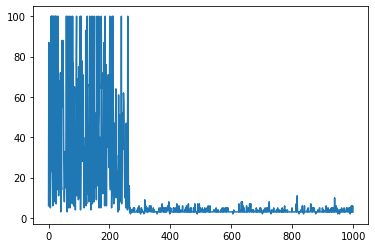

In [25]:
plt.plot(steps)